In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-03-01 17:47:54,333 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
results_dir = '../../results/newLOO/fit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
pickle_files

array(['../../results/newLOO/fit/A-fit-swarm_12-005_2018-02-14_17-05-35.pickle',
       '../../results/newLOO/fit/A-fit-swarm_51-009_2018-02-14_17-14-10.pickle',
       '../../results/newLOO/fit/A-fit-swarm_52-001_2018-02-14_17-24-19.pickle',
       '../../results/newLOO/fit/A-fit-swarm_TB_2018-02-14_17-01-49.pickle',
       '../../results/newLOO/fit/C-fit-swarm_12-005_2018-02-14_09-40-18.pickle',
       '../../results/newLOO/fit/C-fit-swarm_51-009_2018-02-14_10-46-19.pickle',
       '../../results/newLOO/fit/C-fit-swarm_52-001_2018-02-14_13-43-52.pickle',
       '../../results/newLOO/fit/C-fit-swarm_TB_2018-02-14_09-27-36.pickle',
       '../../results/newLOO/fit/D2-fit-swarm_12-005_2018-02-13_19-50-19.pickle',
       '../../results/newLOO/fit/D2-fit-swarm_51-009_2018-02-14_01-12-34.pickle',
       '../../results/newLOO/fit/D2-fit-swarm_52-001_2018-02-14_07-55-14.pickle',
       '../../results/newLOO/fit/D2-fit-swarm_TB_2018-02-13_18-15-09.pickle',
       '../../results/newLOO/fit/E2-

In [3]:
subjects = ['12-005', '51-009', '52-001', 'TB']
models = ['A', 'C', 'D2', 'E2', 'F2']
assert_params = {
    'amplitude': 2.0,
    'w_scale': 20,
    'w_rot': 0,
    'w_dice': 80
}

In [4]:
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
drawing_error = {s: {} for s in subjects}
idx_el = {s: None for s in subjects}
for subject in subjects:
    print('Calculating drawing error: %s' % subject)
    X, y = p2pspatial.load_data(os.path.join(rootfolder, subject), subject=subject, electrodes=None,
                                amplitude=assert_params['amplitude'], random_state=42,
                                single_stim=True, verbose=False)
    assert len(X) == len(y) != 0
    for e in X.electrode.unique():
        drawings = y[X['electrode'] == e]
        props = [p2pspatial.imgproc.get_region_props(d['image'], thresh=0.5) 
                 for _, d in drawings.iterrows()]
        area = np.std([p.area for p in props])
        err = np.array([np.rad2deg(np.abs(p.orientation)) for p in props])
        err = np.where(err > 180, 360 - err, err)
        orient = np.std(err)
        major_axis = np.std([p.major_axis_length for p in props])
        minor_axis = np.std([p.minor_axis_length for p in props])
        drawing_error[subject][e] = {'area': area, 'orientation': orient,
                                     'major_axis_length': major_axis,
                                     'minor_axis_length': minor_axis}
    X, y = p2pspatial.transform_mean_images(X, y)
    idx_el[subject] = np.array(X.electrode)

Calculating drawing error: 12-005
Calculating drawing error: 51-009
Calculating drawing error: 52-001
Calculating drawing error: TB


In [5]:
def calc_props_loss(y_true, y_pred, specifics, drawing_error, idx_el):
    subject = specifics['subject']
    model = specifics['regressor']
    
    area = []
    orient = []
    for (iyt, yt), (iyp, yp), el in zip(y_true.iterrows(), y_pred.iterrows(), idx_el[subject]):
        if 'image' in yt:
            yt_props = p2pspatial.imgproc.get_region_props(yt['image'], thresh=0.5)
            yt_area = yt_props.area
            yt_orient = yt_props.orientation
        else:
            yt_area = yt['area']
            yt_orient = yt['orientation']

        if 'image' in yp:
            yp_props = p2pspatial.imgproc.get_region_props(yp['image'], thresh=model.img_thresh)
            if yp_props is None:
                yp_area = 0
                yp_orient = 0
            else:
                yp_area = yp_props.area
                yp_orient = yp_props.orientation
        else:
            yp_area = yp['area']
            yp_orient = yp['orientation']
        assert iyt == iyp
        assert el in drawing_error[subject]

        # Calc relative error: area
        err = np.sqrt((yt_area - yp_area) ** 2) / drawing_error[subject][el]['area']
        area.append(err)
        
        # Calc relative error: orientation
        err = np.rad2deg(np.abs(yt_orient - yp_orient))
        err = 360 - err if err > 180 else err
        err = np.sqrt(err ** 2) / drawing_error[subject][el]['orientation']
        orient.append(err)
        
    return {'area': area, 'orientation': orient}

In [7]:
loss = {a: {s: None for s in subjects} for a in models}
for file in pickle_files:
    loaddata = pickle.load(open(file, 'rb'))
    if len(loaddata) < 4:
        print(loaddata)
        continue
    _, _, best_params, specifics = loaddata
    for key, value in six.iteritems(assert_params):
        assert np.isclose(specifics[key], value)
    n_folds = specifics['n_folds']
    assert n_folds == 1
#     print(len(best_params), n_folds)
#     assert len(best_params) == n_folds
    model = specifics['modelname']
    subject = specifics['subject']
    if model not in models:
        print('Model %s found, skip.' % model)
        continue
    if subject not in subjects:
        print('Subject %s found, skip.' % subject)
        continue
    print('Processing Model %s, Subject %s' % (model, subject))
    
    X, y = p2pspatial.load_data(os.path.join(rootfolder, subject), subject=subject, electrodes=None,
                                amplitude=assert_params['amplitude'], random_state=42,
                                single_stim=True, verbose=False)

    y_pred = specifics['regressor'].predict(X)
    loss[model][subject] = calc_props_loss(y, y_pred, specifics, drawing_error, idx_el)

Processing Model A, Subject 12-005
Processing Model A, Subject 51-009


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars


Processing Model A, Subject 52-001
Processing Model A, Subject TB
Processing Model C, Subject 12-005
Processing Model C, Subject 51-009


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars


Processing Model C, Subject 52-001
Processing Model C, Subject TB
Processing Model D2, Subject 12-005
Processing Model D2, Subject 51-009


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars


Processing Model D2, Subject 52-001
Processing Model D2, Subject TB
Processing Model E2, Subject 12-005
Processing Model E2, Subject 51-009


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars


Processing Model E2, Subject 52-001
Processing Model E2, Subject TB
Processing Model F2, Subject 12-005
Processing Model F2, Subject 51-009


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars


Processing Model F2, Subject 52-001
Processing Model F2, Subject TB


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


TypeError: string indices must be integers

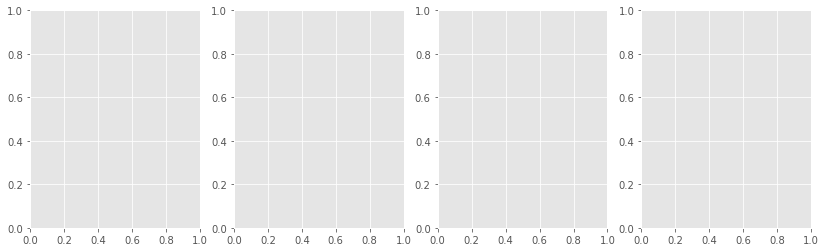

In [8]:
cols = ['area', 'orientation']
N = len(cols)
width = 0.3 / N
ind = np.arange(N)

fig, axes = plt.subplots(ncols=len(subjects), figsize=(14, 4), sharex=True)
cm = plt.get_cmap('hot')

for ax, subject in zip(axes.ravel(), subjects):
    rects = {}
    for m, model in enumerate(models):
        for c, col in enumerate(cols):
            if not loss[model][subject]:
                continue
            attr = [l[col] for l in loss[model][subject]]
            attr = [item for sublist in attr for item in sublist]
            r = ax.bar(c + m * width, np.mean(attr), width, yerr=np.std(attr), 
                       color=cm(m / len(models)), edgecolor='k', 
                       label='Model %s' % model)
            rects[model] = r[0]
    ax.set_xticks(ind + 0.5 * (len(models) - 1) * width)
    ax.set_xticklabels(cols, rotation=45, ha='center', fontsize=12)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_title('MSE: %s' % subject, fontsize=16)
fig.suptitle(os.path.basename(os.path.dirname(results_dir)), fontsize=20)
fig.legend([rects[m] for m in models if m in rects],
          ['Model ' + m for m in models if m in rects], 
          ncol=4, loc='lower center', fontsize=12)
fig.tight_layout(rect=[0, 0.1, 1, 0.9])
fig.savefig(os.path.join(results_dir, 'mse_props_loss.png'))